# **Alzheimer MRI Disease Classification**

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.



## 🎄 **LeNet** 모델링 (by 수연)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

(…)-00000-of-00001-c08a401c53fe5312.parquet:   0%|          | 0.00/22.6M [00:00<?, ?B/s]

(…)-00000-of-00001-44110b9df98c5585.parquet:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1280 [00:00<?, ? examples/s]

Epoch [1/15] - Train Loss: 1.0406, Train Acc: 0.4879, Test Loss: 0.9645, Test Acc: 0.5344
Epoch [2/15] - Train Loss: 0.9431, Train Acc: 0.5371, Test Loss: 0.9429, Test Acc: 0.5492
Epoch [3/15] - Train Loss: 0.9110, Train Acc: 0.5527, Test Loss: 0.9242, Test Acc: 0.5383
Epoch [4/15] - Train Loss: 0.8784, Train Acc: 0.5715, Test Loss: 0.8648, Test Acc: 0.5773
Epoch [5/15] - Train Loss: 0.8489, Train Acc: 0.5910, Test Loss: 0.8585, Test Acc: 0.5875
Epoch [6/15] - Train Loss: 0.7652, Train Acc: 0.6438, Test Loss: 0.7709, Test Acc: 0.6344
Epoch [7/15] - Train Loss: 0.6527, Train Acc: 0.7047, Test Loss: 0.6382, Test Acc: 0.7070
Epoch [8/15] - Train Loss: 0.5397, Train Acc: 0.7725, Test Loss: 0.5285, Test Acc: 0.7734
Epoch [9/15] - Train Loss: 0.3549, Train Acc: 0.8613, Test Loss: 0.3840, Test Acc: 0.8477
Epoch [10/15] - Train Loss: 0.2051, Train Acc: 0.9229, Test Loss: 0.2035, Test Acc: 0.9281
Epoch [11/15] - Train Loss: 0.1075, Train Acc: 0.9629, Test Loss: 0.2860, Test Acc: 0.8906
Epoch [1

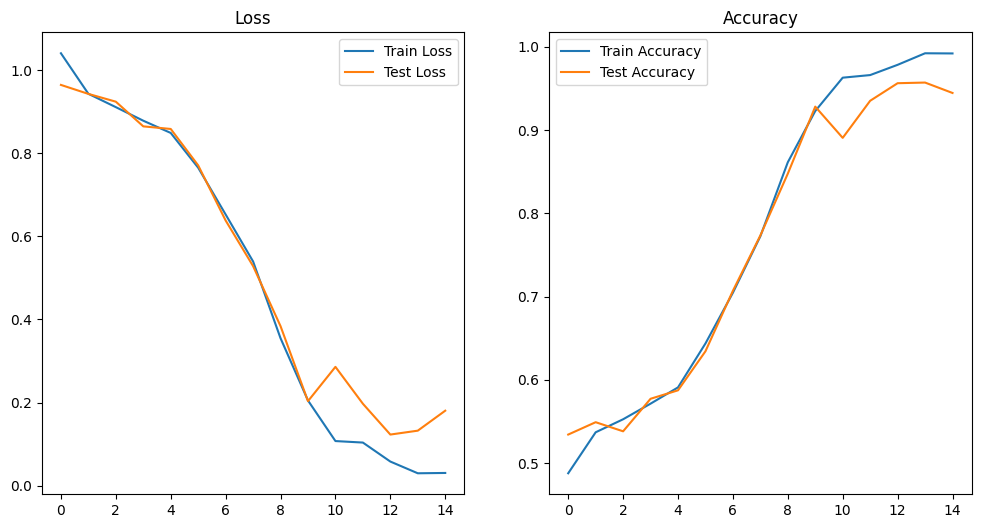

F1-Score: 0.9448, Accuracy: 0.9445


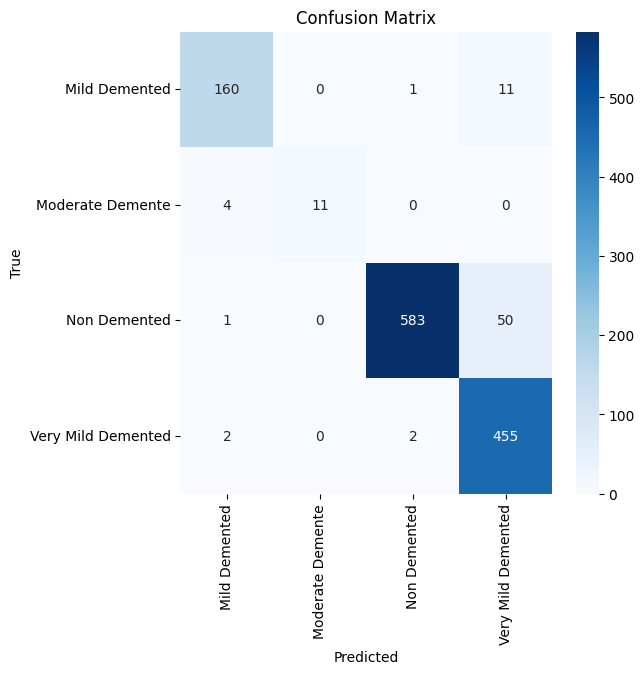

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import load_dataset
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# 1. Load Dataset
train_dataset = load_dataset('Falah/Alzheimer_MRI', split='train')
test_dataset = load_dataset('Falah/Alzheimer_MRI', split='test')

# 2. Define Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 128x128
    transforms.ToTensor(),          # Convert to PyTorch Tensor
])

# 3. Define PyTorch Dataset
class AlzheimerMRIDataset(Dataset):
    def __init__(self, dataset, num_classes, transform=None):
        self.dataset = dataset
        self.transform = transform
        self.num_classes = num_classes  # Number of classes

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Access row
        item = self.dataset[idx]
        # Load image
        image = item['image']  # Should be PIL Image or JpegImageFile
        # Apply transformation if defined
        if self.transform:
            image = self.transform(image)
        # Load label
        label = item['label']

        return image, label

# 4. Determine Number of Classes
# Assuming the labels are integers starting from 0 to the number of classes-1
num_classes = len(set(item['label'] for item in train_dataset))  # Get unique classes

# 5. Create PyTorch Dataset
train_dataset = AlzheimerMRIDataset(train_dataset, num_classes=num_classes, transform=transform)
test_dataset = AlzheimerMRIDataset(test_dataset, num_classes=num_classes, transform=transform)

# 6. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

input_shape = train_dataset[0][0].shape
output_shape = train_dataset.num_classes


## model definition

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.fe = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(5,5), stride=1, padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,5), stride=1, padding=2),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=(2,2), stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=1, padding=1),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=(2,2), stride=2, padding=0)
        )

        self.flatten = nn.Flatten()

        self.fcs = nn.Sequential(
            nn.Linear(64*32*32,1024),
            nn.LeakyReLU(),
            nn.Linear(1024,512),
            nn.LeakyReLU(),
            nn.Linear(512,256),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(256, output_shape)
        )


    def forward(self,x):

        hidden = self.fe(x)
        hidden = self.flatten(hidden)
        output = self.fcs(hidden)

        return output


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = LeNet().to(device)
loss_function = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-3)


num_epochs = 15
train_loss_list, test_loss_list = [], []
train_acc_list, test_acc_list = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct_train, total_train = 0, 0, 0

    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        # Forward pass
        y_pred = model(x)

        # Calculate loss
        loss = loss_function(y_pred, y)
        total_loss += loss.item() * x.size(0)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, preds = torch.max(y_pred, 1)
        correct_train += torch.sum(preds == y).item()
        total_train += y.size(0)

    # Compute average loss and accuracy
    avg_train_loss = total_loss / total_train
    train_accuracy = correct_train / total_train
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_accuracy)

    # Evaluation on the test set
    model.eval()
    total_loss, correct_test, total_test = 0, 0, 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)

            # Calculate loss
            loss = loss_function(y_pred, y)
            total_loss += loss.item() * x.size(0)

            # Calculate accuracy
            _, preds = torch.max(y_pred, 1)
            correct_test += torch.sum(preds == y).item()
            total_test += y.size(0)

    avg_test_loss = total_loss / total_test
    test_accuracy = correct_test / total_test
    test_loss_list.append(avg_test_loss)
    test_acc_list.append(test_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.4f}")



# 11. Plot Training and Test Loss/Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

# 12. Calculate F1-Score and Confusion Matrix
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_true.extend(y.cpu().numpy())
        outputs = model(x)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())

# F1-Score and Accuracy
f1 = f1_score(y_true, y_pred, average='weighted')
acc = accuracy_score(y_true, y_pred)
print(f"F1-Score: {f1:.4f}, Accuracy: {acc:.4f}")

# Confusion Matrix
label_names = ["Mild Demented", "Moderate Demente", "Non Demented", "Very Mild Demented"]

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 🎄 새로운 이미지 평가 (by 인애)

In [3]:
import os

# 현재 작업 디렉토리 확인
current_dir = os.getcwd()
print("Current directory:", current_dir)


Current directory: /content


In [4]:
!ls

A_ND_1.png  B_VMD_1.png  C_MD_1.png  D_MOD_1.png  sample_data
A_ND_2.png  B_VMD_2.png  C_MD_2.png  D_MOD_2.png


### 새로운 외부 이미지 불러오기
- 1번째 이미지 출처
  - https://www.researchgate.net/figure/Samples-of-MRI-images-representing-different-AD-stages-1-MD-2-MOD-3-ND-4-VMD_fig1_355174632
- 2번째 이미지 출처
  - https://www.researchgate.net/figure/Example-samples-of-the-KAGGLE-Alzheimers-dataset-A-Non-AD-B-Moderate-AD-C_fig1_360869690

In [17]:
from PIL import Image
import torch
import torchvision.transforms as transforms

# External Image Classification and Visualization
external_images = ['A_ND_1.png', 'B_VMD_1.png', 'C_MD_1.png', 'D_MOD_1.png',
 'A_ND_2.png', 'B_VMD_2.png', 'C_MD_2.png', 'D_MOD_2.png']


# Function to assign labels based on image name prefix
def get_label_from_filename(filename):
    if filename.startswith('A_ND'):
        return 2  # Non_Demented
    elif filename.startswith('B_VMD'):
        return 3  # Very_Mild_Demented
    elif filename.startswith('C_MD'):
        return 0  # Mild_Demented
    elif filename.startswith('D_MOD'):
        return 1  # Moderate_Demented
    return -1  # Default if no match


### 라벨 별로 시각화

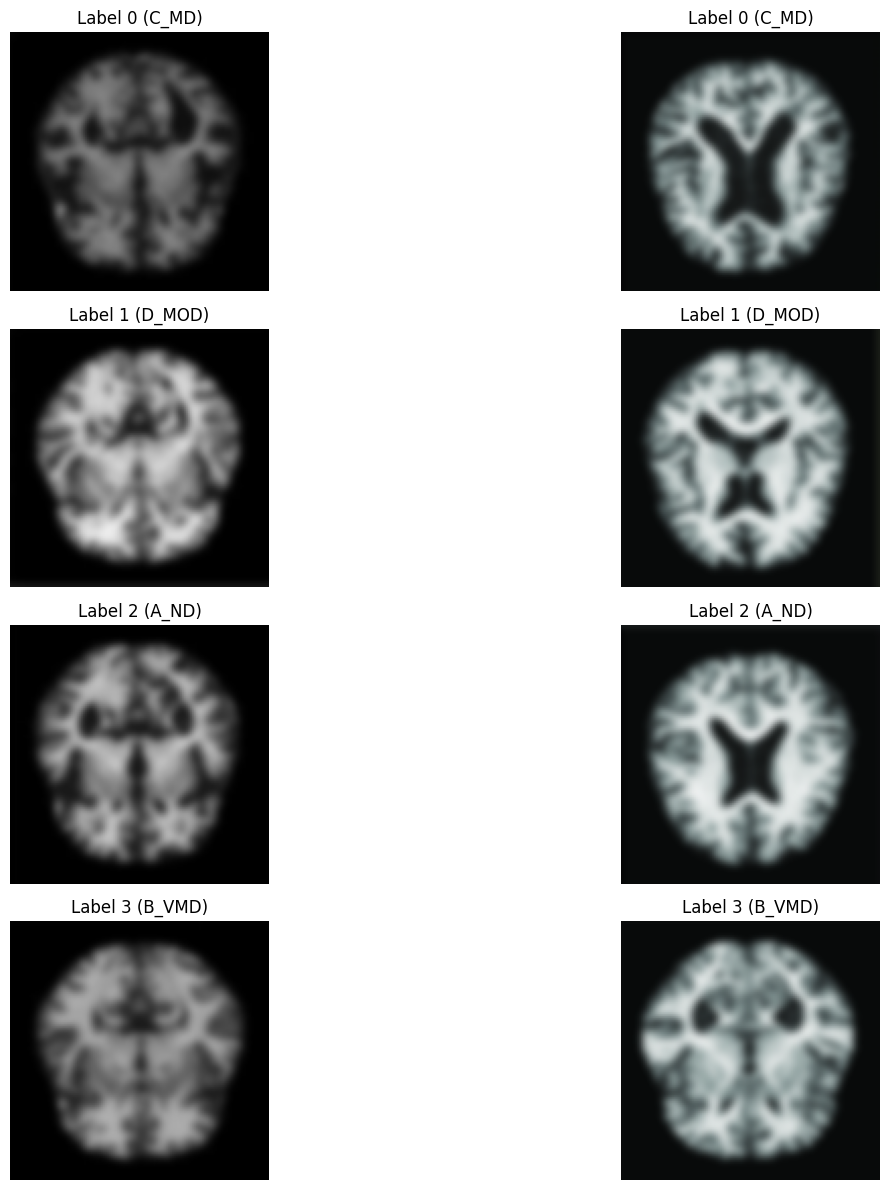

In [20]:
from PIL import Image, ImageFilter

# Apply GaussianBlur to each image and group by label
blurred_images = {'0': [], '1': [], '2': [], '3': []}  # Dictionary to store blurred images by label
external_labels = []

for img_path in external_images:
    img = Image.open(img_path)
    img = img.resize((128, 128))  # Resize for consistency
    img_blurred = img.filter(ImageFilter.GaussianBlur(radius=2))  # Apply GaussianBlur

    label = get_label_from_filename(img_path)
    blurred_images[str(label)].append(img_blurred)  # Add blurred image to corresponding label list
    external_labels.append(label)

# Visualize blurred images grouped by label
fig, axes = plt.subplots(4, len(blurred_images['0']), figsize=(16, 12))  # Adjust based on number of images
axes = axes.flatten()

label_names = ['C_MD', 'D_MOD', 'A_ND', 'B_VMD']

# Loop through each label and show blurred images
for label_idx, label in enumerate(blurred_images):
    for i, img in enumerate(blurred_images[label]):
        ax = axes[label_idx * len(blurred_images['0']) + i]  # Adjust index to place images correctly
        ax.imshow(img)
        ax.set_title(f"Label {label} ({label_names[label_idx]})")
        ax.axis('off')

plt.tight_layout()
plt.show()

### 라벨링 및 분류

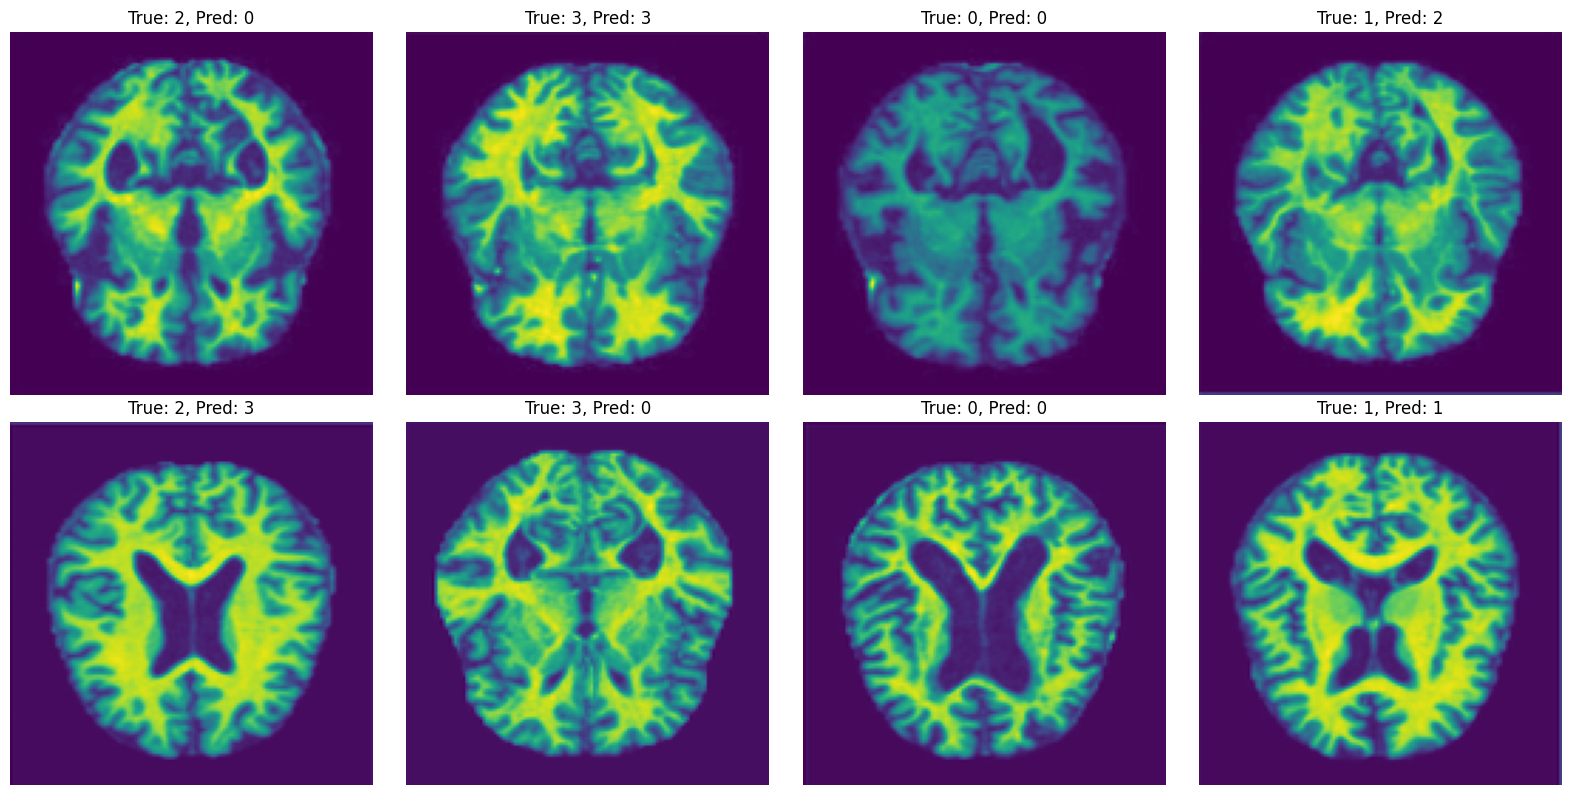

In [19]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Transformations for external images (3-channel, resized to 128x128)
external_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Lambda(lambda x: x.convert('L')),  # Convert to 1 channel (grayscale) - works on PIL image
    transforms.ToTensor(),
])


# 외부 이미지 라벨링
external_image_data = []
external_labels = []

for img_path in external_images:
    img = Image.open(img_path)
    img = external_transform(img)  # Apply the transformation (resize and convert to 1 channel)
    external_image_data.append(img)

    # 라벨링
    label = get_label_from_filename(img_path)
    external_labels.append(label)

# Convert lists to tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
external_images_tensor = torch.stack(external_image_data).to(device)
external_labels_tensor = torch.tensor(external_labels).to(device)



# 외부 이미지 분류 (예측)
model.eval()
with torch.no_grad():
    outputs = model(external_images_tensor)  # Forward pass
    _, preds = torch.max(outputs, 1)  # Get predictions

# Visualize images and predictions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(external_image_data[i].permute(1, 2, 0).cpu().numpy())  # Convert tensor to image for visualization
    ax.set_title(f"True: {external_labels[i]}, Pred: {preds[i].item()}")
    ax.axis('off')

plt.tight_layout()
plt.show()


### 분류 결과 시각화

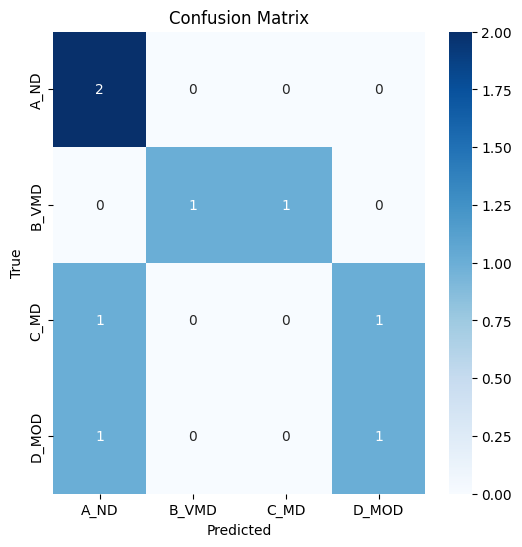

Correct Predictions: 4 / 8
Incorrect Predictions: 4 / 8


In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(external_labels, preds.cpu().numpy())

# Visualize confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['A_ND', 'B_VMD', 'C_MD', 'D_MOD'], yticklabels=['A_ND', 'B_VMD', 'C_MD', 'D_MOD'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Calculate the number of correct and incorrect predictions
correct_predictions = torch.sum(preds == external_labels_tensor).item()
total_predictions = len(external_labels)
incorrect_predictions = total_predictions - correct_predictions

print(f"Correct Predictions: {correct_predictions} / {total_predictions}")
print(f"Incorrect Predictions: {incorrect_predictions} / {total_predictions}")


### 라벨 별로 정답, 오답 여부를 히스토그램으로 시각화

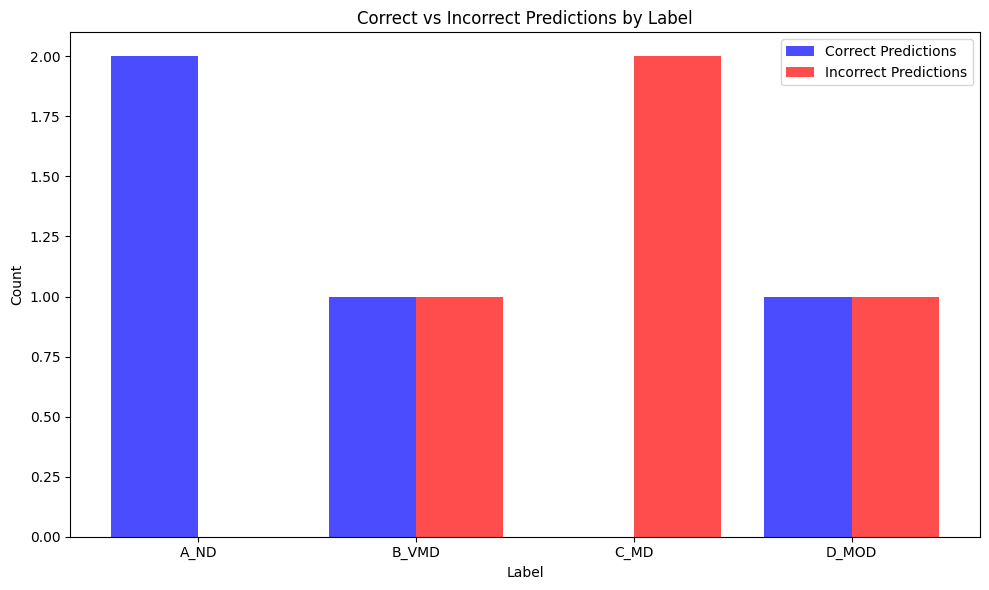

In [26]:
# Correct and Incorrect Predictions by Label
correct_by_label = [0] * 4  # Initialize for 4 classes
incorrect_by_label = [0] * 4

# Classify correct vs incorrect predictions by label
for true_label, pred_label in zip(external_labels_tensor, preds):
    if true_label == pred_label:
        correct_by_label[true_label.item()] += 1
    else:
        incorrect_by_label[true_label.item()] += 1

# Labels for the x-axis
labels = ["A_ND", "B_VMD", "C_MD", "D_MOD"]

# Create the histogram
x = np.arange(len(labels))  # X-axis positions for the 4 labels

plt.figure(figsize=(10, 6))

# Plot correct predictions
plt.bar(x - 0.2, correct_by_label, 0.4, label="Correct Predictions", color='b', alpha=0.7)

# Plot incorrect predictions
plt.bar(x + 0.2, incorrect_by_label, 0.4, label="Incorrect Predictions", color='r', alpha=0.7)

# Labeling the chart
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Correct vs Incorrect Predictions by Label")
plt.xticks(x, labels)
plt.legend()
plt.tight_layout()

plt.show()